In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.backend import get_value
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../'
sys.path.insert(0, path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

['../../mavenn']


In [2]:
# Import dataset splitter from sklearn
from sklearn.model_selection import train_test_split

# Load dataset as a dataframe
data_df = mavenn.load_example_dataset('mpsa')

# Extract x and y as np.arrays
x = data_df['x'].values
y = data_df['y'].values

# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

In [3]:
# Define a model with a pairwise G-P map
# a heteroskedastic Gaussian GE measurement process,
# and specify the training data.
mavenn.set_seed(0)

model = mavenn.Model(x=x_train,
                     y=y_train,
                     gpmap_type='pairwise',
                     alphabet='dna',
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_nonlinearity_monotonic=True,
                     ge_heteroskedasticity_order=2)

# Fit model to training data
start_time = time.time()
model.fit(epochs=10,
          learning_rate=0.005,
          early_stopping=True,
          early_stopping_patience=20)
training_time = time.time()-start_time
print(f'training time: {training_time:.1f} seconds')

Epoch 1/10
264/264 [==============================] - 1s 3ms/step - loss: 146.2141 - val_loss: 127.0500
Epoch 2/10
264/264 [==============================] - 0s 2ms/step - loss: 103.8758 - val_loss: 75.2944
Epoch 3/10
264/264 [==============================] - 0s 2ms/step - loss: 60.7059 - val_loss: 49.5150
Epoch 4/10
264/264 [==============================] - 0s 2ms/step - loss: 50.0541 - val_loss: 47.6768
Epoch 5/10
264/264 [==============================] - 0s 2ms/step - loss: 48.9957 - val_loss: 46.9040
Epoch 6/10
264/264 [==============================] - 0s 2ms/step - loss: 48.6342 - val_loss: 46.7333
Epoch 7/10
264/264 [==============================] - 0s 2ms/step - loss: 48.1343 - val_loss: 45.9864
Epoch 8/10
264/264 [==============================] - 0s 2ms/step - loss: 47.5224 - val_loss: 45.3189
Epoch 9/10
264/264 [==============================] - 0s 2ms/step - loss: 46.4746 - val_loss: 44.1614
Epoch 10/10
264/264 [==============================] - 0s 2ms/step - loss: 45.4

In [4]:
model.arg_dict.keys()

dict_keys(['x', 'y', 'alphabet', 'regression_type', 'gpmap_type', 'ct_n', 'ge_nonlinearity_monotonic', 'ge_nonlinearity_hidden_nodes', 'ge_noise_model_type', 'ge_heteroskedasticity_order', 'na_hidden_nodes', 'theta_regularization', 'eta_regularization', 'ohe_batch_size'])

In [5]:
# Save model
model.save('mpsa')

Model saved to these files:
	mpsa.pickle
	mpsa.h5


In [6]:
# Load model
model = mavenn.load('mpsa')
model.get_nn().summary()

Model loaded from these files:
	mpsa.pickle
	mpsa.h5
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 613)]        0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 612)          0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
phi (Dense)                     (None, 1)            613         Sequence_only[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           100         phi[0][0]                        
__________________________________

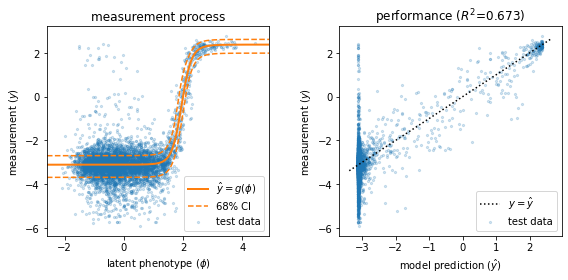

In [9]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Compute R^2 between yhat and y_test
Rsq = np.corrcoef(yhat_test.ravel(), y_test)[0, 1]**2

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 68% CI for each yhat
yqs_grid = model.yhat_to_yq(yhat_grid, q=[0.16, 0.84])

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=[8, 4])

# Left panel: illustrate measurement process (y vs. phi)
ax = axs[0]
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Center panel: illustrate model performance (y vs. yhat)
ax = axs[1]
#ys = np.vstack([y_test])
ax.scatter(yhat_test, y_test, color='C0', s=5, alpha=.2, label='test data')
#ax.set_autoscale_on(False)
lims = ax.get_xlim()
ax.plot(lims, lims, linestyle=':', color='k', label='$y=\hat{y}$')
ax.set_xlabel('model prediction ($\hat{y}$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'performance ($R^2$={Rsq:.3})')
ax.legend()

# Tighten bounds on figure
fig.tight_layout(w_pad=3)
plt.show()

In [10]:
# Compute mask_dict from trainig data
mask_dict = mavenn.get_mask_dict(x_train, alphabet='dna')
mask_dict

{3: 'ACT', 4: 'AG'}

In [11]:
wt_seq = mavenn.x_to_consensus(x_train)

theta_add_df = model.get_gpmap_parameters(which='additive')
theta_add_df.head()

,name,value,l,c
0,theta_0:A,0.085996,0,A
1,theta_0:C,0.171193,0,C
2,theta_0:G,-0.132118,0,G
3,theta_0:T,-0.125071,0,T
4,theta_1:A,0.255366,1,A


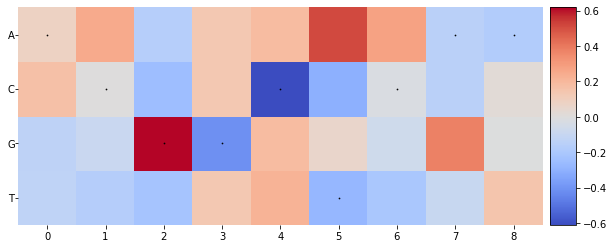

In [12]:
# Illustrate pairwise parameters
fig, ax = plt.subplots(1,1, figsize=[10,4])
ax, cb = mavenn.heatmap(theta_add_df,
                        ax=ax,
                        seq=wt_seq,
                        ccenter=0,
                        #mask_dict=mask_dict,
                        missing_values=0)

In [13]:
theta_pair_df = model.get_gpmap_parameters(which='pairwise')
theta_pair_df.head()

,name,value,l1,c1,l2,c2
0,"theta_0:A,1:A",0.018185,0,A,1,A
1,"theta_0:A,1:C",0.041975,0,A,1,C
2,"theta_0:A,1:G",-0.083727,0,A,1,G
3,"theta_0:A,1:T",0.023567,0,A,1,T
4,"theta_0:A,2:A",-0.051899,0,A,2,A


In [14]:
all(theta_pair_df['l2'] - theta_pair_df['l1'] == 1)

False

Automatically determined gpmap_type=pairwise.


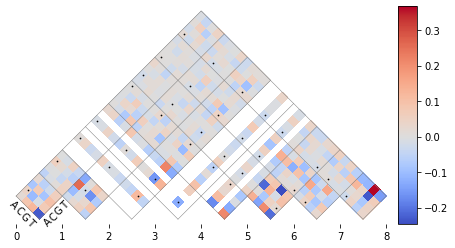

In [15]:
# Illustrate pairwise parameters
fig, ax = plt.subplots(1,1, figsize=[10,4])
ax, cb = mavenn.heatmap_pairwise(theta_pair_df,
                                 ccenter=0,
                                 ax=ax,
                                 seq=wt_seq,
                                 mask_dict=mask_dict)